Using TensorFlow backend.


(50000, 28, 28) (50000,)


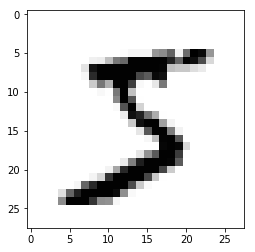

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

## Preparation

Relaunch tensorboard, and import useful libraries.

In [2]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

import tensorflow as tf

import numpy as np

No matching processes belonging to you were found


# Data inspection and preparation

We first take a look at the data, and prepare a version having just two classes.

In [ ]:
X_train.shape

In [3]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

Let's create a flattened version of the data, because tensorflow has difficulty computing gradients across a reshape node.

In [ ]:
with tf.variable_scope("1nn-reshaper"):
    # input shape
    x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(y, 10)
    flat_x = tf.reshape(x, [-1, rows * cols])

X_train_flat, y_train_one_hot = s.run([flat_x, one_hot_y], feed_dict={
    x: X_train,
    y: y_train
})

## Single layer neural network

We first create a simple single layer neural network. We use a one_hot encode layer and a reshape layer to create a flat X. This will prove to be troublesome in the future, but it works for the first version. We use a softmax function to compute the predicted classes.

Also, for debugging, we create the `correct_prediction` and `accuracy` nodes, to avoid having to compute these metrics by hand after running the network.

In [4]:
rows = 28
cols = 28
classes = 10

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn"):
    weights = tf.get_variable("weights", 
                              [rows * cols, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=1e-3),
                              dtype=tf.float32)
    b = tf.get_variable("bias", [classes],
                    initializer=tf.random_uniform_initializer(minval=0, maxval=1e-3),
                    dtype=tf.float32)

    input_X = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    input_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(input_y, classes)
    flat_X = tf.reshape(input_X, [-1, rows * cols])
    
    predicted_y = tf.nn.softmax(tf.matmul(flat_X, weights) + b)
    class_loss = -tf.log(predicted_y) * one_hot_y - tf.log(1 - predicted_y) * (1 - one_hot_y)
    loss = tf.reduce_mean(class_loss)
    
    correct_prediction = tf.equal(tf.cast(input_y, tf.int64), tf.argmax(predicted_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

Let's test that the weights get correctly initialized.

In [5]:
s.run(tf.global_variables_initializer())
print(s.run([weights, b]))

[array([[  5.79033105e-04,   5.30614925e-04,   3.36251920e-04, ...,
          2.76694028e-03,   1.15641451e-03,  -1.63831748e-03],
       [ -1.58736168e-03,   1.21381214e-04,  -2.19016010e-03, ...,
          1.32015243e-03,   4.94840438e-04,   1.25256577e-03],
       [ -3.99170749e-05,   3.11565556e-04,   6.22138497e-04, ...,
         -6.53253344e-04,   4.62306161e-05,  -8.24748189e-04],
       ..., 
       [  1.43660349e-04,  -8.87794231e-05,   2.98190513e-04, ...,
          2.59238703e-04,   4.58338851e-04,  -1.08343644e-04],
       [  8.14772618e-04,   6.56542543e-04,   1.24888425e-03, ...,
         -9.27994843e-04,  -7.12979992e-04,   1.58063893e-03],
       [  5.21749025e-04,  -1.53792300e-03,   1.33906677e-03, ...,
         -1.45935116e-03,  -2.51419330e-03,   1.67449866e-03]], dtype=float32), array([  2.86260271e-04,   9.36999510e-04,   8.29001729e-05,
         5.16016968e-04,   8.68820585e-04,   6.75416377e-04,
         8.76370585e-04,   2.40242618e-04,   2.61650217e-04,
      

Let's test that the network computes different values correctly, or at least that they seem to be roughly correct. I struggled a bit with different data shapes and wrong initialization. I decided to keep this step to show what pains I went through.

In [7]:
s.run([weights, b, predicted_y, class_loss, one_hot_y, loss, correct_prediction, accuracy],
     {
         input_X: X_train[:3],
         input_y: y_train[:3]
     })

[array([[  5.79033105e-04,   5.30614925e-04,   3.36251920e-04, ...,
           2.76694028e-03,   1.15641451e-03,  -1.63831748e-03],
        [ -1.58736168e-03,   1.21381214e-04,  -2.19016010e-03, ...,
           1.32015243e-03,   4.94840438e-04,   1.25256577e-03],
        [ -3.99170749e-05,   3.11565556e-04,   6.22138497e-04, ...,
          -6.53253344e-04,   4.62306161e-05,  -8.24748189e-04],
        ..., 
        [  1.43660349e-04,  -8.87794231e-05,   2.98190513e-04, ...,
           2.59238703e-04,   4.58338851e-04,  -1.08343644e-04],
        [  8.14772618e-04,   6.56542543e-04,   1.24888425e-03, ...,
          -9.27994843e-04,  -7.12979992e-04,   1.58063893e-03],
        [  5.21749025e-04,  -1.53792300e-03,   1.33906677e-03, ...,
          -1.45935116e-03,  -2.51419330e-03,   1.67449866e-03]], dtype=float32),
 array([  2.86260271e-04,   9.36999510e-04,   8.29001729e-05,
          5.16016968e-04,   8.68820585e-04,   6.75416377e-04,
          8.76370585e-04,   2.40242618e-04,   2.61650

Finally, compute accuracy metrics when training the network.

In [8]:
s.run(tf.global_variables_initializer())

losses = []
test_accuracies = []
train_accuracies = []

for i in range(30):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss,  {input_X: X_train, input_y: y_train})
    losses += [loss_i]
    train_accuracies += [s.run(accuracy, {input_X:X_train, input_y: y_train})]
    test_accuracies += [s.run(accuracy, {input_X:X_test, input_y: y_test})]


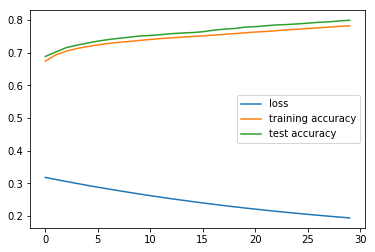

In [9]:
plt.figure()
plt.plot(losses);
plt.plot(train_accuracies)
plt.plot(test_accuracies);
plt.legend(['loss', 'training accuracy', 'test accuracy'])


## Multilayer neural network

In this neural network, we use a second 50 neuron layer. The first layer has a sigmoid activation function.

In [43]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

import tensorflow as tf

rows = 28
cols = 28
classes = 10

hidden_size = 256

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 1e-1
    print("sigma", sigma)
  
    # input layer
    W1 = tf.get_variable("weights", 
                              [rows * cols, hidden_size],
                              initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                              dtype=tf.float32)
    b1 = tf.get_variable("bias", [hidden_size],
                    initializer=tf.zeros_initializer(),
                    dtype=tf.float32)

    y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

    # hidden layer
    W2 = tf.get_variable("hidden_weights", 
                              [hidden_size, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                              dtype=tf.float32)
    b2 = tf.get_variable("hidden_bias", [classes],
                    initializer=tf.zeros_initializer(),
                    dtype=tf.float32)

    y2 = tf.nn.softmax(tf.matmul(y1, W2) + b2)

    class_loss = -tf.log(y2) * y_ - tf.log(1 - y2) * (1 - y_)
    loss = tf.reduce_mean(class_loss)

    # output
    y = y2

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    s.run(tf.global_variables_initializer())



(50000, 28, 28) (50000,)
sigma 0.1


Next, we create a generator that will provide us with randomized minibatches, to do incremental training.

In [41]:
import random

class MiniBatchGenerator:
    def __init__(self, X, y, batch_size):
        self.X = X.copy()
        self.y = y.copy()
        self.batch_size = batch_size
        self.current_i = 0
        self.total_size = len(self.X)
        
        self.reshuffle()
        
    def reshuffle(self):        
        idxs = list(range(self.total_size))
        random.shuffle(idxs)
        self.X_shuffled = self.X[idxs]
        self.y_shuffled = self.y[idxs]        
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        res_X = []
        res_y = []
        
        end_i = self.current_i + self.batch_size
        
        if end_i > self.total_size:
            rem = end_i - self.total_size
            res_X = self.X_shuffled[self.current_i:]
            res_y = self.y_shuffled[self.current_i:]
            self.reshuffle()
            res_X = np.append(res_X, self.X_shuffled[:rem], axis=0)
            res_y = np.append(res_y, self.y_shuffled[:rem])
            self.current_i = rem
        else:
            res_X = self.X_shuffled[self.current_i:end_i]
            res_y = self.y_shuffled[self.current_i:end_i]
            self.current_i = end_i
        
        return res_X, res_y

In [42]:
s.run(tf.global_variables_initializer())
for i in range(30):
    s.run(optimizer, {input_x: X_train, label_y: y_train})
    loss_i = s.run(loss,  {input_x: X_train, label_y: y_train})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train accuracy:", s.run(accuracy, {input_x:X_train, label_y: y_train}))
    print("test accuracy:", s.run(accuracy, {input_x:X_test, label_y: y_test}))
    print()

loss at iter 0:2.3463
train accuracy: 0.09904
test accuracy: 0.1086

loss at iter 1:2.2990
train accuracy: 0.13884
test accuracy: 0.1473

loss at iter 2:2.2710
train accuracy: 0.1714
test accuracy: 0.178

loss at iter 3:2.2476
train accuracy: 0.19918
test accuracy: 0.2075

loss at iter 4:2.2250
train accuracy: 0.22688
test accuracy: 0.2376

loss at iter 5:2.2029
train accuracy: 0.25676
test accuracy: 0.2685

loss at iter 6:2.1811
train accuracy: 0.2857
test accuracy: 0.2982

loss at iter 7:2.1596
train accuracy: 0.31466
test accuracy: 0.3299

loss at iter 8:2.1385
train accuracy: 0.34234
test accuracy: 0.3552

loss at iter 9:2.1176
train accuracy: 0.36848
test accuracy: 0.382

loss at iter 10:2.0970
train accuracy: 0.39304
test accuracy: 0.4086

loss at iter 11:2.0767
train accuracy: 0.41628
test accuracy: 0.4342

loss at iter 12:2.0567
train accuracy: 0.43814
test accuracy: 0.4561

loss at iter 13:2.0369
train accuracy: 0.45886
test accuracy: 0.475

loss at iter 14:2.0175
train accura

In [44]:
s.run(tf.global_variables_initializer())

batcher = MiniBatchGenerator(X_train, y_train, 1000)
print(X_train.shape)
print(y_train.shape)

for i in range(10000):
    X_batch, y_batch = batcher.next()
    
    loss_i, accuracy_i, optimizer_i = s.run([
        loss, accuracy, optimizer
    ],  {input_x: X_batch, 
                     label_y: y_batch})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train accuracy:", accuracy_i)

accuracy_i = s.run([
    accuracy
],  {input_x: X_test, 
     label_y: y_test})

print("test_accuracy:", accuracy_i)


(50000, 28, 28)
(50000,)
loss at iter 0:2.5946
train accuracy: 0.1
loss at iter 1:2.3307
train accuracy: 0.103
loss at iter 2:2.3103
train accuracy: 0.142
loss at iter 3:2.2943
train accuracy: 0.122
loss at iter 4:2.2598
train accuracy: 0.163
loss at iter 5:2.2220
train accuracy: 0.202
loss at iter 6:2.1951
train accuracy: 0.225
loss at iter 7:2.1749
train accuracy: 0.26
loss at iter 8:2.1646
train accuracy: 0.315
loss at iter 9:2.1281
train accuracy: 0.339
loss at iter 10:2.1077
train accuracy: 0.321
loss at iter 11:2.0957
train accuracy: 0.371
loss at iter 12:2.0827
train accuracy: 0.369
loss at iter 13:2.0473
train accuracy: 0.386
loss at iter 14:2.0176
train accuracy: 0.422
loss at iter 15:2.0109
train accuracy: 0.422
loss at iter 16:2.0006
train accuracy: 0.421
loss at iter 17:1.9717
train accuracy: 0.474
loss at iter 18:1.9536
train accuracy: 0.509
loss at iter 19:1.9339
train accuracy: 0.501
loss at iter 20:1.9014
train accuracy: 0.553
loss at iter 21:1.9024
train accuracy: 0.54

loss at iter 186:0.7429
train accuracy: 0.836
loss at iter 187:0.7590
train accuracy: 0.82
loss at iter 188:0.6849
train accuracy: 0.863
loss at iter 189:0.7443
train accuracy: 0.833
loss at iter 190:0.6978
train accuracy: 0.862
loss at iter 191:0.7204
train accuracy: 0.839
loss at iter 192:0.6966
train accuracy: 0.876
loss at iter 193:0.6939
train accuracy: 0.85
loss at iter 194:0.7026
train accuracy: 0.846
loss at iter 195:0.6915
train accuracy: 0.851
loss at iter 196:0.7049
train accuracy: 0.833
loss at iter 197:0.7265
train accuracy: 0.841
loss at iter 198:0.7178
train accuracy: 0.846
loss at iter 199:0.7185
train accuracy: 0.831
loss at iter 200:0.6862
train accuracy: 0.849
loss at iter 201:0.7119
train accuracy: 0.843
loss at iter 202:0.6900
train accuracy: 0.853
loss at iter 203:0.6971
train accuracy: 0.845
loss at iter 204:0.7041
train accuracy: 0.841
loss at iter 205:0.7013
train accuracy: 0.842
loss at iter 206:0.6814
train accuracy: 0.85
loss at iter 207:0.7240
train accurac

loss at iter 375:0.5352
train accuracy: 0.871
loss at iter 376:0.5378
train accuracy: 0.864
loss at iter 377:0.5676
train accuracy: 0.851
loss at iter 378:0.5307
train accuracy: 0.868
loss at iter 379:0.5280
train accuracy: 0.872
loss at iter 380:0.4846
train accuracy: 0.886
loss at iter 381:0.5021
train accuracy: 0.875
loss at iter 382:0.5082
train accuracy: 0.875
loss at iter 383:0.4820
train accuracy: 0.89
loss at iter 384:0.5068
train accuracy: 0.88
loss at iter 385:0.5610
train accuracy: 0.835
loss at iter 386:0.5203
train accuracy: 0.873
loss at iter 387:0.5020
train accuracy: 0.875
loss at iter 388:0.4788
train accuracy: 0.875
loss at iter 389:0.5062
train accuracy: 0.858
loss at iter 390:0.5456
train accuracy: 0.842
loss at iter 391:0.5134
train accuracy: 0.867
loss at iter 392:0.4967
train accuracy: 0.885
loss at iter 393:0.5197
train accuracy: 0.875
loss at iter 394:0.5063
train accuracy: 0.871
loss at iter 395:0.4978
train accuracy: 0.87
loss at iter 396:0.4610
train accurac

loss at iter 563:0.4618
train accuracy: 0.877
loss at iter 564:0.4537
train accuracy: 0.877
loss at iter 565:0.4595
train accuracy: 0.874
loss at iter 566:0.4266
train accuracy: 0.883
loss at iter 567:0.3874
train accuracy: 0.906
loss at iter 568:0.4365
train accuracy: 0.892
loss at iter 569:0.4784
train accuracy: 0.867
loss at iter 570:0.4536
train accuracy: 0.885
loss at iter 571:0.4416
train accuracy: 0.883
loss at iter 572:0.4224
train accuracy: 0.894
loss at iter 573:0.4551
train accuracy: 0.87
loss at iter 574:0.4457
train accuracy: 0.881
loss at iter 575:0.4388
train accuracy: 0.891
loss at iter 576:0.4464
train accuracy: 0.886
loss at iter 577:0.4698
train accuracy: 0.866
loss at iter 578:0.4181
train accuracy: 0.891
loss at iter 579:0.4652
train accuracy: 0.882
loss at iter 580:0.3688
train accuracy: 0.915
loss at iter 581:0.4319
train accuracy: 0.884
loss at iter 582:0.4748
train accuracy: 0.868
loss at iter 583:0.4144
train accuracy: 0.899
loss at iter 584:0.4328
train accur

loss at iter 749:0.3909
train accuracy: 0.881
loss at iter 750:0.3847
train accuracy: 0.895
loss at iter 751:0.4442
train accuracy: 0.882
loss at iter 752:0.3689
train accuracy: 0.916
loss at iter 753:0.4392
train accuracy: 0.886
loss at iter 754:0.4362
train accuracy: 0.88
loss at iter 755:0.3732
train accuracy: 0.908
loss at iter 756:0.3963
train accuracy: 0.888
loss at iter 757:0.4236
train accuracy: 0.88
loss at iter 758:0.4139
train accuracy: 0.892
loss at iter 759:0.4075
train accuracy: 0.887
loss at iter 760:0.4050
train accuracy: 0.886
loss at iter 761:0.4098
train accuracy: 0.875
loss at iter 762:0.3881
train accuracy: 0.893
loss at iter 763:0.4129
train accuracy: 0.886
loss at iter 764:0.4060
train accuracy: 0.888
loss at iter 765:0.3925
train accuracy: 0.894
loss at iter 766:0.4140
train accuracy: 0.887
loss at iter 767:0.3951
train accuracy: 0.884
loss at iter 768:0.3928
train accuracy: 0.89
loss at iter 769:0.4054
train accuracy: 0.898
loss at iter 770:0.3982
train accurac

loss at iter 937:0.3794
train accuracy: 0.906
loss at iter 938:0.3807
train accuracy: 0.896
loss at iter 939:0.3687
train accuracy: 0.899
loss at iter 940:0.3710
train accuracy: 0.889
loss at iter 941:0.3454
train accuracy: 0.906
loss at iter 942:0.3605
train accuracy: 0.904
loss at iter 943:0.3625
train accuracy: 0.892
loss at iter 944:0.3610
train accuracy: 0.897
loss at iter 945:0.3851
train accuracy: 0.893
loss at iter 946:0.3496
train accuracy: 0.906
loss at iter 947:0.4312
train accuracy: 0.865
loss at iter 948:0.3811
train accuracy: 0.895
loss at iter 949:0.3561
train accuracy: 0.898
loss at iter 950:0.3885
train accuracy: 0.889
loss at iter 951:0.4092
train accuracy: 0.881
loss at iter 952:0.3900
train accuracy: 0.9
loss at iter 953:0.3799
train accuracy: 0.901
loss at iter 954:0.3624
train accuracy: 0.91
loss at iter 955:0.3879
train accuracy: 0.898
loss at iter 956:0.3861
train accuracy: 0.897
loss at iter 957:0.3759
train accuracy: 0.899
loss at iter 958:0.3576
train accurac

loss at iter 1126:0.3831
train accuracy: 0.881
loss at iter 1127:0.3266
train accuracy: 0.905
loss at iter 1128:0.3593
train accuracy: 0.894
loss at iter 1129:0.3560
train accuracy: 0.913
loss at iter 1130:0.3330
train accuracy: 0.908
loss at iter 1131:0.3538
train accuracy: 0.896
loss at iter 1132:0.3644
train accuracy: 0.903
loss at iter 1133:0.3722
train accuracy: 0.9
loss at iter 1134:0.3771
train accuracy: 0.905
loss at iter 1135:0.3550
train accuracy: 0.904
loss at iter 1136:0.3662
train accuracy: 0.893
loss at iter 1137:0.3629
train accuracy: 0.903
loss at iter 1138:0.3710
train accuracy: 0.904
loss at iter 1139:0.4090
train accuracy: 0.889
loss at iter 1140:0.3577
train accuracy: 0.907
loss at iter 1141:0.3888
train accuracy: 0.89
loss at iter 1142:0.3332
train accuracy: 0.919
loss at iter 1143:0.3709
train accuracy: 0.895
loss at iter 1144:0.3470
train accuracy: 0.908
loss at iter 1145:0.3799
train accuracy: 0.884
loss at iter 1146:0.3687
train accuracy: 0.889
loss at iter 114

loss at iter 1310:0.3649
train accuracy: 0.904
loss at iter 1311:0.3787
train accuracy: 0.895
loss at iter 1312:0.3454
train accuracy: 0.906
loss at iter 1313:0.3782
train accuracy: 0.906
loss at iter 1314:0.3320
train accuracy: 0.9
loss at iter 1315:0.3052
train accuracy: 0.903
loss at iter 1316:0.3501
train accuracy: 0.902
loss at iter 1317:0.3183
train accuracy: 0.916
loss at iter 1318:0.3805
train accuracy: 0.899
loss at iter 1319:0.3398
train accuracy: 0.899
loss at iter 1320:0.3392
train accuracy: 0.902
loss at iter 1321:0.3277
train accuracy: 0.903
loss at iter 1322:0.3246
train accuracy: 0.909
loss at iter 1323:0.3287
train accuracy: 0.908
loss at iter 1324:0.3689
train accuracy: 0.903
loss at iter 1325:0.3368
train accuracy: 0.908
loss at iter 1326:0.3891
train accuracy: 0.894
loss at iter 1327:0.3601
train accuracy: 0.888
loss at iter 1328:0.3521
train accuracy: 0.897
loss at iter 1329:0.3353
train accuracy: 0.901
loss at iter 1330:0.3367
train accuracy: 0.907
loss at iter 13

loss at iter 1496:0.2614
train accuracy: 0.936
loss at iter 1497:0.2924
train accuracy: 0.929
loss at iter 1498:0.3191
train accuracy: 0.909
loss at iter 1499:0.3723
train accuracy: 0.901
loss at iter 1500:0.2938
train accuracy: 0.918
loss at iter 1501:0.3636
train accuracy: 0.902
loss at iter 1502:0.3103
train accuracy: 0.917
loss at iter 1503:0.3427
train accuracy: 0.905
loss at iter 1504:0.3259
train accuracy: 0.904
loss at iter 1505:0.3398
train accuracy: 0.918
loss at iter 1506:0.3392
train accuracy: 0.905
loss at iter 1507:0.3567
train accuracy: 0.894
loss at iter 1508:0.3502
train accuracy: 0.901
loss at iter 1509:0.2951
train accuracy: 0.915
loss at iter 1510:0.3635
train accuracy: 0.909
loss at iter 1511:0.3210
train accuracy: 0.907
loss at iter 1512:0.3310
train accuracy: 0.906
loss at iter 1513:0.3318
train accuracy: 0.911
loss at iter 1514:0.3273
train accuracy: 0.912
loss at iter 1515:0.3227
train accuracy: 0.907
loss at iter 1516:0.3524
train accuracy: 0.905
loss at iter 

loss at iter 1676:0.3238
train accuracy: 0.908
loss at iter 1677:0.3541
train accuracy: 0.904
loss at iter 1678:0.3176
train accuracy: 0.914
loss at iter 1679:0.3119
train accuracy: 0.914
loss at iter 1680:0.3132
train accuracy: 0.905
loss at iter 1681:0.3247
train accuracy: 0.898
loss at iter 1682:0.3170
train accuracy: 0.904
loss at iter 1683:0.3325
train accuracy: 0.906
loss at iter 1684:0.3310
train accuracy: 0.903
loss at iter 1685:0.3175
train accuracy: 0.918
loss at iter 1686:0.3620
train accuracy: 0.887
loss at iter 1687:0.2935
train accuracy: 0.919
loss at iter 1688:0.2879
train accuracy: 0.914
loss at iter 1689:0.3264
train accuracy: 0.891
loss at iter 1690:0.3714
train accuracy: 0.905
loss at iter 1691:0.2988
train accuracy: 0.919
loss at iter 1692:0.3126
train accuracy: 0.908
loss at iter 1693:0.2899
train accuracy: 0.922
loss at iter 1694:0.2954
train accuracy: 0.921
loss at iter 1695:0.2908
train accuracy: 0.921
loss at iter 1696:0.3692
train accuracy: 0.897
loss at iter 

loss at iter 1863:0.3090
train accuracy: 0.916
loss at iter 1864:0.3000
train accuracy: 0.906
loss at iter 1865:0.3129
train accuracy: 0.904
loss at iter 1866:0.2894
train accuracy: 0.921
loss at iter 1867:0.3304
train accuracy: 0.903
loss at iter 1868:0.3514
train accuracy: 0.894
loss at iter 1869:0.2795
train accuracy: 0.919
loss at iter 1870:0.3446
train accuracy: 0.904
loss at iter 1871:0.3490
train accuracy: 0.896
loss at iter 1872:0.3254
train accuracy: 0.903
loss at iter 1873:0.3025
train accuracy: 0.911
loss at iter 1874:0.3479
train accuracy: 0.897
loss at iter 1875:0.2865
train accuracy: 0.921
loss at iter 1876:0.2931
train accuracy: 0.922
loss at iter 1877:0.3542
train accuracy: 0.889
loss at iter 1878:0.3142
train accuracy: 0.914
loss at iter 1879:0.3521
train accuracy: 0.899
loss at iter 1880:0.3267
train accuracy: 0.907
loss at iter 1881:0.3200
train accuracy: 0.907
loss at iter 1882:0.3167
train accuracy: 0.911
loss at iter 1883:0.3537
train accuracy: 0.903
loss at iter 

loss at iter 2050:0.2929
train accuracy: 0.914
loss at iter 2051:0.3640
train accuracy: 0.886
loss at iter 2052:0.3145
train accuracy: 0.916
loss at iter 2053:0.3462
train accuracy: 0.906
loss at iter 2054:0.3382
train accuracy: 0.893
loss at iter 2055:0.2941
train accuracy: 0.922
loss at iter 2056:0.3279
train accuracy: 0.908
loss at iter 2057:0.2815
train accuracy: 0.927
loss at iter 2058:0.3307
train accuracy: 0.904
loss at iter 2059:0.3802
train accuracy: 0.902
loss at iter 2060:0.3146
train accuracy: 0.917
loss at iter 2061:0.3118
train accuracy: 0.91
loss at iter 2062:0.2779
train accuracy: 0.911
loss at iter 2063:0.2959
train accuracy: 0.927
loss at iter 2064:0.3173
train accuracy: 0.899
loss at iter 2065:0.3048
train accuracy: 0.922
loss at iter 2066:0.3070
train accuracy: 0.908
loss at iter 2067:0.3111
train accuracy: 0.915
loss at iter 2068:0.3057
train accuracy: 0.913
loss at iter 2069:0.3275
train accuracy: 0.907
loss at iter 2070:0.2942
train accuracy: 0.92
loss at iter 20

loss at iter 2226:0.2915
train accuracy: 0.921
loss at iter 2227:0.3512
train accuracy: 0.9
loss at iter 2228:0.3405
train accuracy: 0.91
loss at iter 2229:0.2850
train accuracy: 0.917
loss at iter 2230:0.2873
train accuracy: 0.914
loss at iter 2231:0.3171
train accuracy: 0.908
loss at iter 2232:0.2525
train accuracy: 0.931
loss at iter 2233:0.2978
train accuracy: 0.918
loss at iter 2234:0.2780
train accuracy: 0.919
loss at iter 2235:0.3793
train accuracy: 0.904
loss at iter 2236:0.3103
train accuracy: 0.912
loss at iter 2237:0.3071
train accuracy: 0.912
loss at iter 2238:0.2957
train accuracy: 0.915
loss at iter 2239:0.3012
train accuracy: 0.914
loss at iter 2240:0.3264
train accuracy: 0.913
loss at iter 2241:0.3125
train accuracy: 0.909
loss at iter 2242:0.2756
train accuracy: 0.916
loss at iter 2243:0.2784
train accuracy: 0.926
loss at iter 2244:0.3069
train accuracy: 0.918
loss at iter 2245:0.3383
train accuracy: 0.9
loss at iter 2246:0.3123
train accuracy: 0.909
loss at iter 2247:

loss at iter 2414:0.2944
train accuracy: 0.919
loss at iter 2415:0.2845
train accuracy: 0.913
loss at iter 2416:0.2763
train accuracy: 0.917
loss at iter 2417:0.2814
train accuracy: 0.929
loss at iter 2418:0.3063
train accuracy: 0.912
loss at iter 2419:0.3340
train accuracy: 0.908
loss at iter 2420:0.3098
train accuracy: 0.906
loss at iter 2421:0.2725
train accuracy: 0.922
loss at iter 2422:0.3117
train accuracy: 0.921
loss at iter 2423:0.3287
train accuracy: 0.912
loss at iter 2424:0.2830
train accuracy: 0.921
loss at iter 2425:0.3061
train accuracy: 0.908
loss at iter 2426:0.2799
train accuracy: 0.906
loss at iter 2427:0.2894
train accuracy: 0.918
loss at iter 2428:0.2893
train accuracy: 0.925
loss at iter 2429:0.2907
train accuracy: 0.919
loss at iter 2430:0.3070
train accuracy: 0.914
loss at iter 2431:0.3335
train accuracy: 0.908
loss at iter 2432:0.3070
train accuracy: 0.919
loss at iter 2433:0.3518
train accuracy: 0.904
loss at iter 2434:0.3034
train accuracy: 0.917
loss at iter 

loss at iter 2591:0.2871
train accuracy: 0.925
loss at iter 2592:0.3236
train accuracy: 0.916
loss at iter 2593:0.3026
train accuracy: 0.905
loss at iter 2594:0.2949
train accuracy: 0.917
loss at iter 2595:0.3084
train accuracy: 0.908
loss at iter 2596:0.3001
train accuracy: 0.91
loss at iter 2597:0.2974
train accuracy: 0.918
loss at iter 2598:0.2887
train accuracy: 0.913
loss at iter 2599:0.3119
train accuracy: 0.921
loss at iter 2600:0.2939
train accuracy: 0.922
loss at iter 2601:0.2943
train accuracy: 0.92
loss at iter 2602:0.2686
train accuracy: 0.923
loss at iter 2603:0.3477
train accuracy: 0.896
loss at iter 2604:0.3233
train accuracy: 0.907
loss at iter 2605:0.2902
train accuracy: 0.911
loss at iter 2606:0.3018
train accuracy: 0.911
loss at iter 2607:0.2891
train accuracy: 0.917
loss at iter 2608:0.2821
train accuracy: 0.922
loss at iter 2609:0.2795
train accuracy: 0.919
loss at iter 2610:0.2937
train accuracy: 0.919
loss at iter 2611:0.2881
train accuracy: 0.926
loss at iter 26

loss at iter 2776:0.3060
train accuracy: 0.904
loss at iter 2777:0.2932
train accuracy: 0.91
loss at iter 2778:0.3383
train accuracy: 0.897
loss at iter 2779:0.2518
train accuracy: 0.93
loss at iter 2780:0.3037
train accuracy: 0.918
loss at iter 2781:0.3122
train accuracy: 0.911
loss at iter 2782:0.2915
train accuracy: 0.918
loss at iter 2783:0.3163
train accuracy: 0.91
loss at iter 2784:0.2441
train accuracy: 0.927
loss at iter 2785:0.3093
train accuracy: 0.911
loss at iter 2786:0.2884
train accuracy: 0.914
loss at iter 2787:0.2646
train accuracy: 0.93
loss at iter 2788:0.3343
train accuracy: 0.911
loss at iter 2789:0.2911
train accuracy: 0.927
loss at iter 2790:0.2983
train accuracy: 0.914
loss at iter 2791:0.2766
train accuracy: 0.917
loss at iter 2792:0.2603
train accuracy: 0.922
loss at iter 2793:0.3002
train accuracy: 0.915
loss at iter 2794:0.3185
train accuracy: 0.907
loss at iter 2795:0.3040
train accuracy: 0.919
loss at iter 2796:0.3177
train accuracy: 0.915
loss at iter 2797

loss at iter 2962:0.2666
train accuracy: 0.924
loss at iter 2963:0.2665
train accuracy: 0.929
loss at iter 2964:0.2582
train accuracy: 0.925
loss at iter 2965:0.2539
train accuracy: 0.926
loss at iter 2966:0.3146
train accuracy: 0.905
loss at iter 2967:0.2581
train accuracy: 0.921
loss at iter 2968:0.2821
train accuracy: 0.92
loss at iter 2969:0.2725
train accuracy: 0.927
loss at iter 2970:0.2831
train accuracy: 0.917
loss at iter 2971:0.2615
train accuracy: 0.928
loss at iter 2972:0.2857
train accuracy: 0.909
loss at iter 2973:0.2795
train accuracy: 0.928
loss at iter 2974:0.3085
train accuracy: 0.905
loss at iter 2975:0.2770
train accuracy: 0.92
loss at iter 2976:0.3028
train accuracy: 0.908
loss at iter 2977:0.3396
train accuracy: 0.907
loss at iter 2978:0.3107
train accuracy: 0.906
loss at iter 2979:0.2813
train accuracy: 0.919
loss at iter 2980:0.2972
train accuracy: 0.921
loss at iter 2981:0.2878
train accuracy: 0.918
loss at iter 2982:0.2457
train accuracy: 0.92
loss at iter 298

loss at iter 3139:0.2962
train accuracy: 0.921
loss at iter 3140:0.3215
train accuracy: 0.912
loss at iter 3141:0.2642
train accuracy: 0.928
loss at iter 3142:0.3020
train accuracy: 0.905
loss at iter 3143:0.2718
train accuracy: 0.927
loss at iter 3144:0.2644
train accuracy: 0.923
loss at iter 3145:0.2523
train accuracy: 0.926
loss at iter 3146:0.2721
train accuracy: 0.929
loss at iter 3147:0.3122
train accuracy: 0.899
loss at iter 3148:0.2382
train accuracy: 0.93
loss at iter 3149:0.2983
train accuracy: 0.92
loss at iter 3150:0.2912
train accuracy: 0.92
loss at iter 3151:0.2676
train accuracy: 0.926
loss at iter 3152:0.2680
train accuracy: 0.923
loss at iter 3153:0.3050
train accuracy: 0.912
loss at iter 3154:0.2322
train accuracy: 0.931
loss at iter 3155:0.2777
train accuracy: 0.921
loss at iter 3156:0.2657
train accuracy: 0.918
loss at iter 3157:0.2695
train accuracy: 0.926
loss at iter 3158:0.3092
train accuracy: 0.919
loss at iter 3159:0.3203
train accuracy: 0.906
loss at iter 316

loss at iter 3325:0.2505
train accuracy: 0.936
loss at iter 3326:0.2791
train accuracy: 0.919
loss at iter 3327:0.2425
train accuracy: 0.935
loss at iter 3328:0.2704
train accuracy: 0.927
loss at iter 3329:0.2596
train accuracy: 0.934
loss at iter 3330:0.3182
train accuracy: 0.904
loss at iter 3331:0.2828
train accuracy: 0.913
loss at iter 3332:0.2762
train accuracy: 0.921
loss at iter 3333:0.2620
train accuracy: 0.919
loss at iter 3334:0.3234
train accuracy: 0.908
loss at iter 3335:0.3020
train accuracy: 0.916
loss at iter 3336:0.2072
train accuracy: 0.947
loss at iter 3337:0.2744
train accuracy: 0.928
loss at iter 3338:0.2795
train accuracy: 0.921
loss at iter 3339:0.2659
train accuracy: 0.925
loss at iter 3340:0.3380
train accuracy: 0.902
loss at iter 3341:0.2870
train accuracy: 0.921
loss at iter 3342:0.2878
train accuracy: 0.92
loss at iter 3343:0.2960
train accuracy: 0.915
loss at iter 3344:0.2554
train accuracy: 0.934
loss at iter 3345:0.2580
train accuracy: 0.93
loss at iter 33

loss at iter 3500:0.2750
train accuracy: 0.913
loss at iter 3501:0.2338
train accuracy: 0.935
loss at iter 3502:0.2922
train accuracy: 0.91
loss at iter 3503:0.2512
train accuracy: 0.933
loss at iter 3504:0.2438
train accuracy: 0.932
loss at iter 3505:0.2873
train accuracy: 0.925
loss at iter 3506:0.2811
train accuracy: 0.914
loss at iter 3507:0.2306
train accuracy: 0.937
loss at iter 3508:0.3196
train accuracy: 0.917
loss at iter 3509:0.2405
train accuracy: 0.934
loss at iter 3510:0.2664
train accuracy: 0.92
loss at iter 3511:0.2837
train accuracy: 0.917
loss at iter 3512:0.2903
train accuracy: 0.92
loss at iter 3513:0.2776
train accuracy: 0.925
loss at iter 3514:0.2594
train accuracy: 0.925
loss at iter 3515:0.2780
train accuracy: 0.912
loss at iter 3516:0.2556
train accuracy: 0.931
loss at iter 3517:0.2311
train accuracy: 0.934
loss at iter 3518:0.2656
train accuracy: 0.923
loss at iter 3519:0.2870
train accuracy: 0.911
loss at iter 3520:0.2799
train accuracy: 0.917
loss at iter 352

loss at iter 3676:0.2783
train accuracy: 0.922
loss at iter 3677:0.3172
train accuracy: 0.906
loss at iter 3678:0.2743
train accuracy: 0.916
loss at iter 3679:0.2856
train accuracy: 0.933
loss at iter 3680:0.2302
train accuracy: 0.932
loss at iter 3681:0.2754
train accuracy: 0.933
loss at iter 3682:0.2638
train accuracy: 0.926
loss at iter 3683:0.2419
train accuracy: 0.928
loss at iter 3684:0.2486
train accuracy: 0.927
loss at iter 3685:0.2476
train accuracy: 0.933
loss at iter 3686:0.2365
train accuracy: 0.935
loss at iter 3687:0.2960
train accuracy: 0.915
loss at iter 3688:0.2735
train accuracy: 0.93
loss at iter 3689:0.2865
train accuracy: 0.916
loss at iter 3690:0.2393
train accuracy: 0.934
loss at iter 3691:0.2501
train accuracy: 0.935
loss at iter 3692:0.2688
train accuracy: 0.921
loss at iter 3693:0.3218
train accuracy: 0.904
loss at iter 3694:0.2620
train accuracy: 0.925
loss at iter 3695:0.2886
train accuracy: 0.92
loss at iter 3696:0.2525
train accuracy: 0.93
loss at iter 369

loss at iter 3863:0.2500
train accuracy: 0.922
loss at iter 3864:0.2354
train accuracy: 0.927
loss at iter 3865:0.2533
train accuracy: 0.927
loss at iter 3866:0.2710
train accuracy: 0.917
loss at iter 3867:0.2544
train accuracy: 0.929
loss at iter 3868:0.2983
train accuracy: 0.923
loss at iter 3869:0.2489
train accuracy: 0.928
loss at iter 3870:0.3178
train accuracy: 0.908
loss at iter 3871:0.2734
train accuracy: 0.922
loss at iter 3872:0.2433
train accuracy: 0.931
loss at iter 3873:0.2526
train accuracy: 0.924
loss at iter 3874:0.2607
train accuracy: 0.928
loss at iter 3875:0.2886
train accuracy: 0.908
loss at iter 3876:0.3196
train accuracy: 0.909
loss at iter 3877:0.2398
train accuracy: 0.934
loss at iter 3878:0.2466
train accuracy: 0.933
loss at iter 3879:0.2794
train accuracy: 0.917
loss at iter 3880:0.2808
train accuracy: 0.926
loss at iter 3881:0.2642
train accuracy: 0.932
loss at iter 3882:0.2688
train accuracy: 0.924
loss at iter 3883:0.3112
train accuracy: 0.911
loss at iter 

loss at iter 4040:0.2644
train accuracy: 0.938
loss at iter 4041:0.2517
train accuracy: 0.934
loss at iter 4042:0.2607
train accuracy: 0.932
loss at iter 4043:0.2731
train accuracy: 0.916
loss at iter 4044:0.2579
train accuracy: 0.926
loss at iter 4045:0.2786
train accuracy: 0.919
loss at iter 4046:0.2766
train accuracy: 0.921
loss at iter 4047:0.2637
train accuracy: 0.924
loss at iter 4048:0.2367
train accuracy: 0.929
loss at iter 4049:0.2731
train accuracy: 0.924
loss at iter 4050:0.2672
train accuracy: 0.929
loss at iter 4051:0.2836
train accuracy: 0.91
loss at iter 4052:0.2595
train accuracy: 0.928
loss at iter 4053:0.2401
train accuracy: 0.929
loss at iter 4054:0.2513
train accuracy: 0.926
loss at iter 4055:0.2635
train accuracy: 0.925
loss at iter 4056:0.3036
train accuracy: 0.917
loss at iter 4057:0.2734
train accuracy: 0.925
loss at iter 4058:0.2523
train accuracy: 0.929
loss at iter 4059:0.2688
train accuracy: 0.926
loss at iter 4060:0.2866
train accuracy: 0.93
loss at iter 40

loss at iter 4227:0.2507
train accuracy: 0.93
loss at iter 4228:0.2560
train accuracy: 0.929
loss at iter 4229:0.2679
train accuracy: 0.917
loss at iter 4230:0.2806
train accuracy: 0.919
loss at iter 4231:0.2425
train accuracy: 0.932
loss at iter 4232:0.2318
train accuracy: 0.932
loss at iter 4233:0.2674
train accuracy: 0.926
loss at iter 4234:0.2759
train accuracy: 0.922
loss at iter 4235:0.3063
train accuracy: 0.921
loss at iter 4236:0.2530
train accuracy: 0.929
loss at iter 4237:0.2757
train accuracy: 0.919
loss at iter 4238:0.2705
train accuracy: 0.922
loss at iter 4239:0.2821
train accuracy: 0.926
loss at iter 4240:0.2707
train accuracy: 0.924
loss at iter 4241:0.2682
train accuracy: 0.919
loss at iter 4242:0.2613
train accuracy: 0.928
loss at iter 4243:0.1993
train accuracy: 0.946
loss at iter 4244:0.2953
train accuracy: 0.916
loss at iter 4245:0.2362
train accuracy: 0.928
loss at iter 4246:0.2824
train accuracy: 0.92
loss at iter 4247:0.2618
train accuracy: 0.925
loss at iter 42

loss at iter 4413:0.2586
train accuracy: 0.93
loss at iter 4414:0.2545
train accuracy: 0.927
loss at iter 4415:0.2522
train accuracy: 0.93
loss at iter 4416:0.2608
train accuracy: 0.923
loss at iter 4417:0.2422
train accuracy: 0.945
loss at iter 4418:0.2350
train accuracy: 0.937
loss at iter 4419:0.2637
train accuracy: 0.921
loss at iter 4420:0.2780
train accuracy: 0.927
loss at iter 4421:0.2551
train accuracy: 0.928
loss at iter 4422:0.2494
train accuracy: 0.932
loss at iter 4423:0.2248
train accuracy: 0.938
loss at iter 4424:0.2347
train accuracy: 0.937
loss at iter 4425:0.2870
train accuracy: 0.922
loss at iter 4426:0.2479
train accuracy: 0.93
loss at iter 4427:0.2529
train accuracy: 0.918
loss at iter 4428:0.2252
train accuracy: 0.936
loss at iter 4429:0.2641
train accuracy: 0.919
loss at iter 4430:0.2558
train accuracy: 0.928
loss at iter 4431:0.2410
train accuracy: 0.932
loss at iter 4432:0.2382
train accuracy: 0.926
loss at iter 4433:0.2731
train accuracy: 0.931
loss at iter 443

loss at iter 4589:0.2691
train accuracy: 0.925
loss at iter 4590:0.2389
train accuracy: 0.937
loss at iter 4591:0.2383
train accuracy: 0.936
loss at iter 4592:0.2569
train accuracy: 0.928
loss at iter 4593:0.2624
train accuracy: 0.925
loss at iter 4594:0.3100
train accuracy: 0.914
loss at iter 4595:0.2885
train accuracy: 0.928
loss at iter 4596:0.2936
train accuracy: 0.925
loss at iter 4597:0.2374
train accuracy: 0.926
loss at iter 4598:0.2781
train accuracy: 0.92
loss at iter 4599:0.2197
train accuracy: 0.94
loss at iter 4600:0.2158
train accuracy: 0.94
loss at iter 4601:0.2799
train accuracy: 0.93
loss at iter 4602:0.2647
train accuracy: 0.927
loss at iter 4603:0.2104
train accuracy: 0.942
loss at iter 4604:0.2435
train accuracy: 0.939
loss at iter 4605:0.2563
train accuracy: 0.925
loss at iter 4606:0.2576
train accuracy: 0.928
loss at iter 4607:0.2522
train accuracy: 0.931
loss at iter 4608:0.2655
train accuracy: 0.926
loss at iter 4609:0.2346
train accuracy: 0.931
loss at iter 4610

loss at iter 4775:0.2756
train accuracy: 0.931
loss at iter 4776:0.2568
train accuracy: 0.933
loss at iter 4777:0.2334
train accuracy: 0.937
loss at iter 4778:0.2677
train accuracy: 0.926
loss at iter 4779:0.2663
train accuracy: 0.934
loss at iter 4780:0.2539
train accuracy: 0.926
loss at iter 4781:0.2371
train accuracy: 0.934
loss at iter 4782:0.2414
train accuracy: 0.929
loss at iter 4783:0.2964
train accuracy: 0.914
loss at iter 4784:0.3081
train accuracy: 0.91
loss at iter 4785:0.2310
train accuracy: 0.934
loss at iter 4786:0.2548
train accuracy: 0.919
loss at iter 4787:0.2357
train accuracy: 0.934
loss at iter 4788:0.2967
train accuracy: 0.913
loss at iter 4789:0.2573
train accuracy: 0.934
loss at iter 4790:0.2508
train accuracy: 0.927
loss at iter 4791:0.2820
train accuracy: 0.931
loss at iter 4792:0.2320
train accuracy: 0.933
loss at iter 4793:0.2794
train accuracy: 0.914
loss at iter 4794:0.2072
train accuracy: 0.937
loss at iter 4795:0.2470
train accuracy: 0.921
loss at iter 4

loss at iter 4950:0.2288
train accuracy: 0.931
loss at iter 4951:0.2585
train accuracy: 0.926
loss at iter 4952:0.2435
train accuracy: 0.937
loss at iter 4953:0.2425
train accuracy: 0.928
loss at iter 4954:0.2682
train accuracy: 0.92
loss at iter 4955:0.2004
train accuracy: 0.941
loss at iter 4956:0.2045
train accuracy: 0.942
loss at iter 4957:0.2073
train accuracy: 0.942
loss at iter 4958:0.3151
train accuracy: 0.904
loss at iter 4959:0.2574
train accuracy: 0.916
loss at iter 4960:0.2202
train accuracy: 0.93
loss at iter 4961:0.2356
train accuracy: 0.933
loss at iter 4962:0.2226
train accuracy: 0.947
loss at iter 4963:0.2860
train accuracy: 0.917
loss at iter 4964:0.2188
train accuracy: 0.941
loss at iter 4965:0.2504
train accuracy: 0.927
loss at iter 4966:0.2757
train accuracy: 0.929
loss at iter 4967:0.2610
train accuracy: 0.926
loss at iter 4968:0.2216
train accuracy: 0.946
loss at iter 4969:0.2276
train accuracy: 0.939
loss at iter 4970:0.2234
train accuracy: 0.943
loss at iter 49

loss at iter 5126:0.2080
train accuracy: 0.952
loss at iter 5127:0.2312
train accuracy: 0.941
loss at iter 5128:0.2325
train accuracy: 0.933
loss at iter 5129:0.2439
train accuracy: 0.933
loss at iter 5130:0.2326
train accuracy: 0.935
loss at iter 5131:0.2299
train accuracy: 0.928
loss at iter 5132:0.2535
train accuracy: 0.925
loss at iter 5133:0.2885
train accuracy: 0.926
loss at iter 5134:0.2395
train accuracy: 0.941
loss at iter 5135:0.2038
train accuracy: 0.938
loss at iter 5136:0.2360
train accuracy: 0.935
loss at iter 5137:0.2040
train accuracy: 0.943
loss at iter 5138:0.2095
train accuracy: 0.94
loss at iter 5139:0.2243
train accuracy: 0.94
loss at iter 5140:0.2385
train accuracy: 0.933
loss at iter 5141:0.2175
train accuracy: 0.937
loss at iter 5142:0.2196
train accuracy: 0.936
loss at iter 5143:0.2194
train accuracy: 0.936
loss at iter 5144:0.2370
train accuracy: 0.936
loss at iter 5145:0.3050
train accuracy: 0.921
loss at iter 5146:0.2520
train accuracy: 0.932
loss at iter 51

KeyboardInterrupt: 

In [ ]:
28 * 28 * 100